# Supporting a JWST Proposal with POSEIDON Retrievals

This tutorial will guide you through a typical workflow for examining the feasibility of a JWST proposal science case using POSEIDON.

The steps we will cover are:

1. Generating simulated JWST observations using [PandExo](https://github.com/natashabatalha/PandExo).
2. Scattering the simulated observations about a POSEIDON forward model.
3. Running an atmospheric retrieval on the synthetic JWST observations.

The first portion of this tutorial assumes you have PandExo installed, which is not an official dependency of POSEIDON. Please see the [PandExo documentation](https://natashabatalha.github.io/PandExo/index.html) for installation instructions.  

### What is Your Science Case?

The first part of any proposal is of course to come up with a good idea! 

For our purposes, let's imagine our science goal is to conclusively detect $\rm{CH}_4$ in a hot Jupiter atmosphere — $\rm{CH}_4$ has proven notoriously difficult to detect with Hubble (perhaps indicating it is destroyed by photodissociation), so detecting $\rm{CH}_4$ and constraining its abundance is a rich science question.

If we want to search for $\rm{CH}_4$, let's first examine where this molecule has prominent absorption features. The plot below (from [MacDonald & Lewis, 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...929...20M/abstract)) shows the absorption cross sections for several important chemical species in hot Jupiter atmospheres.


<img src="../../_static/notebook_images/POSEIDON_cross_sections.png" alt="Cross section plot">

We see that $\rm{CH}_4$ has a strong absorption band centred on 3.3 μm which doesn't coincide with many other molecules. So this feature is a good target for our $\rm{CH}_4$ focused JWST proposal.


### Choosing a Planet

Choosing which exoplanet to focus your JWST proposal on involves many consideration. Some common factors include:

- What have previous observations of this planet found?
- Stellar and planetary properties that make the system favourable.
- Theoretical predictions of novel physical or chemical processes in the target planet's atmosphere.

You should ensure a clear justification of your planet, and it's wider significance, is provided in your proposal.

For this tutorial, we are going to choose the hot Jupiter WASP-62b. Our reasoning is as follows:

1. Observation of WASP-62b with the Hubble and Spitzer space telescopes indicate it has a clear atmosphere ([Alam et al., 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...906L..10A/abstract)), which increases the strength of absorption features and avoids composition-cloud degeneracies.
2. WASP-62b is the only known hot Jupiter in the continuous viewing zone of JWST, making it easy to schedule the observation.
3. Theoretical models predict the $\rm{CH}_4$ abundance in WASP-62b's atmosphere should be at detectable levels.

### Selecting a JWST Instrument

Now that we know our wavelength of interest, let's decide on an appropriate JWST instrument that covers the 3.3 μm $\rm{CH}_4$ band.

This graphic is one of my favourite go-to resources for summarising JWST's instrument capabilities (credit: [ExoCTK](https://exoctk.stsci.edu/)):

<img src="../../_static/notebook_images/JWST_instruments.jpg" alt="JWST instrument properties">

For maximum accuracy in retrieved abundances, generally we want the widest wavelength range possible. However, as shown on the right of the figure above, each instrument has a magnitude range limited by the brightness of the host star.

Looking at [SIMBAD](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=wasp-62) for WASP-62, we see that the host star J magnitude is 9.272. Therefore, the star is too bright to use the instrument mode with the widest wavelength range (NIRSpec PRISM). However, there is an ideal mode covering the 3.3 μm $\rm{CH}_4$ band: NIRSpec G395H.

### Running PandExo

Let's proceed to use PandExo to simulate JWST G395H transmission spectra performance for WASP-62b. 

If you do not have PandExo installed, feel free to skip this code cell (the PandExo output from this cell is included in the POSEIDON reference data folder).

<div class="alert alert-info">

  **Note:**

  With POSEIDON installed, you already have the stellar grids required to install PandExo. So when installing PandExo, you can skip over the 'Stellar SEDs' section in the PandExo installation instruction. POSEIDON and PandExo can share the same 'PYSYN_CDBS' environment variable.

</div>

In [1]:
import os

# Force a single core to be used by numpy (mpirun handles parallelisation)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CBLAS_NUM_THREADS'] = '1'

import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
import pandexo.engine.justplotit as jpi
import astropy
import pickle as pk
import numpy as np
import scipy.constants as sc
from spectres import spectres


def write_data(planet_dir, wl_data, bin_size, spectrum, err_data, instrument, 
               N_trans, NRS_detector, NIRISS_order, model):
    
    if (instrument == 'NIRISS SOSS'):
        suffix = '_Ord' + str(NIRISS_order)
    elif ('NIRSpec G' in instrument):
        suffix = '_NRS' + str(NRS_detector)
    else:
        suffix = ''

    f = open(planet_dir + '/' + planet_name + '_' + model + '_' +
             instrument + suffix + '_N_trans_' + str(N_trans) + '.dat','w')

    for j in range(len(wl_data)):
        f.write('%.8f %.8f %.8e %.8e \n' %(wl_data[j], bin_size[j], spectrum[j], err_data[j]))
        
    f.close()

#***** Planet properties *****#

planet_name = 'WASP-62b'

model = 'Proposal'

#***** Observation settings *****#

N_trans = 1     # Number of transits

#***** Instruments properties *****#

instrument = 'NIRSpec G395H'    # E.g. NIRISS SOSS / NIRSpec G395H
NIRISS_order = 1                # 1st or 2nd order for NIRISS SOSS only

# Create output directories

# Specify desired paths of output directories to be created
output_dir = './data'
planet_dir = output_dir + '/' + planet_name
        
# Create main output directory
if (os.path.exists(output_dir) == False):
    os.mkdir(output_dir)

# Create directory for this specific planet
if (os.path.exists(planet_dir) == False):
    os.mkdir(planet_dir)

#***** PandExo settings *****#

Trans_duration = 3.816   # Transit duration of WASP-62b, in hours, from ExoMast

exo_dict = jdi.load_exo_dict()

exo_dict['observation']['sat_level'] = 80                 # Saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'                 # Other option = 'e' for electrons
exo_dict['observation']['noccultations'] = N_trans        # Number of transits
exo_dict['observation']['R'] = None                       # Fixed binning. I usually suggest ZERO binning.. you can always bin later
exo_dict['observation']['baseline'] = 3.0*Trans_duration*60.0*60.0        # Time spent observing out of transit, make sure to specify units
exo_dict['observation']['baseline_unit'] = 'total'         # Total observing time, other option 'frac' = in/out
exo_dict['observation']['noise_floor'] = 10                # This can be a fixed level or it can be a filepath

# The stellar properties below are for WASP-62 from ExoMast and SIMBAD (except for stellar metallicity)
exo_dict['star']['type'] = 'phoenix'        # Phoenix or user (if you have your own)
exo_dict['star']['mag'] = 9.272             # Magnitude of the system
exo_dict['star']['ref_wave'] = 1.25         # For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 6230             # (K)
exo_dict['star']['metal'] = 0.0             # ALWAYS USE 0.0 FOR PHOENIX MODELS (there's a bug at non-solar metallicities)
exo_dict['star']['logg'] = 4.45             # Log surface gravity (cgs)
exo_dict['star']['radius'] = 1
exo_dict['star']['r_unit'] = 'R_sun'    
                         
exo_dict['planet']['type'] = 'constant'
exo_dict['planet']['w_unit'] = 'um'            # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['radius'] = 1               # We're just using a flat spectrum here, will scatter errors about a model later
exo_dict['planet']['r_unit'] = 'R_jup'                 
exo_dict['planet']['f_unit'] = 'rp^2/r*^2'
exo_dict['planet']['transit_duration'] = Trans_duration*60*60.0     # Transit duration in seconds
exo_dict['planet']['td_unit'] = 's'

#***** Begin PandExo run *****#

print("Running PandExo for " + instrument)

# Initialise instrument directory
inst_dict = jdi.load_mode_dict(instrument)

if (instrument == 'NIRISS SOSS'):
    inst_dict["configuration"]["detector"]["subarray"] = 'substrip256'
    inst_dict["strategy"]["order"] = NIRISS_order    

print(inst_dict["configuration"]["detector"]["subarray"])
print(inst_dict["configuration"]["instrument"]["filter"])

# Run PandExo
result = jdi.run_pandexo(exo_dict, inst_dict, output_path = planet_dir, output_file = planet_name + '.p')  

print(result['timing'])

# Load output from run
out = pk.load((open(planet_dir + '/' + planet_name + '.p', 'rb')))

# Call PandExo plotting routine to return simulated data
wl_data, ydata, err_data = jpi.jwst_1d_spec(out, num_tran=N_trans, model=True, plot=False)

# Compute bin half-width for each data point      
half_width = 0.5 * np.diff(wl_data[0], append=np.array([wl_data[0][-1] + (wl_data[0][-1] - wl_data[0][-2])]))

keep_err = 1.0e-3   # Error criteria to keep data point (< 1000 ppm), trims things like data in band gaps

wl_data_out = wl_data[0][np.where(err_data[0] <= keep_err)]
half_width_out = half_width[np.where(err_data[0] <= keep_err)]
ydata_out = ydata[0][np.where(err_data[0] <= keep_err)]
err_data_out = err_data[0][np.where(err_data[0] <= keep_err)]

# For NIRISS, trim data > 0.9 um (large errors, covered by order 1 anyway)
if (('NIRISS' in instrument) and (NIRISS_order == 2)):

    keep_idx = np.argwhere(wl_data_out < 0.9)

    wl_data_out = wl_data_out[keep_idx]
    half_width_out = half_width_out[keep_idx]
    ydata_out = ydata_out[keep_idx]
    err_data_out = err_data_out[keep_idx]

# Store NIRSpec Grism band gap mid locations
band_gaps = {'NIRSpec G140H': 1.335, 'NIRSpec G235H': 2.235, 'NIRSpec G395H': 3.77}

# For NIRSpec, split into NRS1 and NRS2 about the band gap
if ('NIRSpec G' in instrument):

    NRS_1_idx = np.argwhere(wl_data_out < band_gaps[instrument])
    NRS_2_idx = np.argwhere(wl_data_out > band_gaps[instrument])

    wl_NRS_1 = wl_data_out[NRS_1_idx]
    half_width_NRS_1 = half_width_out[NRS_1_idx]
    ydata_NRS_1 = ydata_out[NRS_1_idx]
    err_data_NRS_1 = err_data_out[NRS_1_idx]

    wl_NRS_2 = wl_data_out[NRS_2_idx]
    half_width_NRS_2 = half_width_out[NRS_2_idx]
    ydata_NRS_2 = ydata_out[NRS_2_idx]
    err_data_NRS_2 = err_data_out[NRS_2_idx]

    # Write NRS1
    NRS_detector = 1

    write_data(planet_dir, wl_NRS_1, half_width_NRS_1, ydata_NRS_1, err_data_NRS_1, 
               instrument, N_trans, NRS_detector, NIRISS_order, model)

    # Write NRS2
    NRS_detector = 2
    
    write_data(planet_dir, wl_NRS_2, half_width_NRS_2, ydata_NRS_2, err_data_NRS_2, 
               instrument, N_trans, NRS_detector, NIRISS_order, model)

else:

    NRS_detector = 0   # Dummy value for other instruments 

    # Write newly produced synthetic data to file
    write_data(planet_dir, wl_data_out, half_width_out, ydata_out, err_data_out, instrument, 
               N_trans, NRS_detector, NIRISS_order, model)

print("Mean error = " + str(1.0e6*np.mean(err_data_out)) + " ppm")



Running PandExo for NIRSpec G395H
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
{'Transit Duration': 3.816, 'Seconds per Frame': 0.902, 'Time/Integration incl reset (sec)': 20.746000000000002, 'APT: Num Groups per Integration': 22, 'Num Integrations Out of Transit': 1327, 'Num Integrations In Transit': 663, 'APT: Num Integrations per Occultation': 1990, 'Observing Efficiency (%)': 91.30434782608695, 'Transit+Baseline, no overhead (hrs)': 11.46792777777778, 'Number of Transits': 1}
Mean error = 307.0216274710595 ppm


**Examining raw PandExo output**

Let's use POSEIDON's ``plot_data`` function to examine the output from PandExo for the NIRSpec G395H instrument mode.

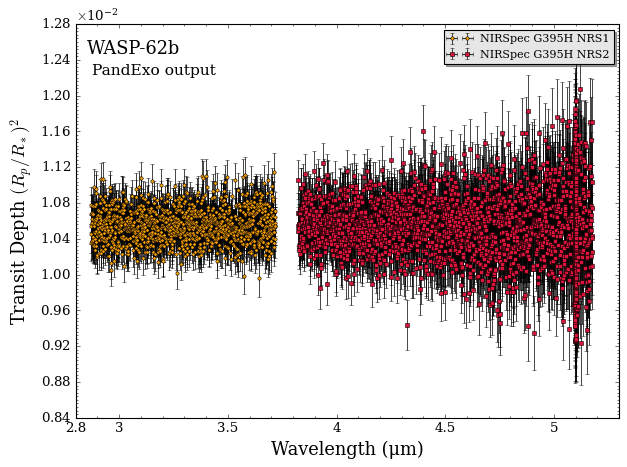

In [2]:
from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

planet_name = 'WASP-62b'  # Planet name used for plots, output files etc.

#***** Model wavelength grid *****#

wl_min = 2.8      # Minimum wavelength (um)
wl_max = 5.3      # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid      

# We need to provide a model wavelength grid to initialise instrument properties
wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Specify data location and instruments  *****#

# If you ran PandExo, leave the next line uncommented
data_dir = './data/' + planet_name  # Directory created by the code cell above

# If you didn't run PandExo, uncomment the next line
#data_dir = '../../../POSEIDON/reference_data/observations/' + planet_name    # Reference directory containing pre-computed PandExo output

# For the G395H instrument, we'll treat each side of the band gap as a separate dataset
datasets = [planet_name + '_CH4_Proposal_NIRSpec G395H_NRS1_N_trans_1.dat',
            planet_name + '_CH4_Proposal_NIRSpec G395H_NRS2_N_trans_1.dat'] 

instruments = ['JWST_NIRSpec_G395H_NRS1', 'JWST_NIRSpec_G395H_NRS2']

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl)

# Plot our data
fig_data = plot_data(data, planet_name, plt_label = 'PandExo output',
                     wl_min = 2.8, wl_max = 5.3, wl_axis = 'linear',
                     data_colour_list = ['orange', 'crimson'],
                     data_labels = ['NIRSpec G395H NRS1', 'NIRSpec G395H NRS2'])

At this point, all we've done is generated simulated JWST observations about a fiducial flat spectrum. Our next step will be to scatter these simulated data points around a POSEIDON model. Before we do that, observe two data aspects from the plot above:

- The PandExo output is at the full resolution of G395H (R ~ 3000).
- There is a band gap between 3.72 μm and 3.82 μm, which partitions the G395H data into the 'NRS1' and 'NRS2' detectors.



### Simulated JWST Data for a POSEIDON Model

Now let's generate a model spectrum for WASP-62b with POSEIDON.

Specify the system properties first.

In [3]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J

#***** Define stellar properties *****#

R_s = 1.23*R_Sun     # Stellar radius (m)
T_s = 6230.0         # Stellar effective temperature (K)
Met_s = 0.04         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.45       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-62b'  # Planet name used for plots, output files etc.

R_p = 1.32*R_J     # Planetary radius (m)
g_p = 7.3978       # Gravitational field of planet (m/s^2)
T_eq = 1394        # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

For our model, we now need to decide on a chemical composition for WASP-62b. There are multiple approaches one can follow at this stage, such as using a chemical equilibrium (or disequilibrium) model, consulting a friendly theorist, or using inferences from previous observations.

Here, we will consider a model containing both $\rm{H}_2 \rm{O}$ and $\rm{CH}_4$. The assumed $\rm{H}_2 \rm{O}$ abundance will be the median retrieved value from the analysis by [Alam et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...906L..10A/abstract) ($\rm{log \, H}_2 \rm{O} = -3.62$), while for the $\rm{CH}_4$ abundance we will use a theoretical prediction for its 10 mbar abundance from the [Goyal et al. (2020)](https://ui.adsabs.harvard.edu/abs/2021ApJ...906L..10A/abstract) self-consistent model grid ($\rm{log \, CH}_4 = -7.46$).

In [4]:
from POSEIDON.core import define_model, read_opacities, \
                          make_atmosphere, compute_spectrum

#***** Define model *****#

model_name = 'CH4_Search_With_JWST'

bulk_species = ['H2', 'He']
param_species = ['H2O', 'CH4']   # Only H2O and CH4 in this model

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 1 mbar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1.0e-2        # 10 mbar
R_p_ref = R_p         # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T_eq])              # Assume terminator temperature is T_eq
log_X_params = np.array([-3.62, -7.46])   # H2O and CH4 log abundances in model

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params)

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 400     # Same as prior range for T
T_fine_max = 2000    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Pre-interpolate the opacities (note: model wavelength range was initialised in cell above)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# Compute spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
H2O done
CH4 done
Opacity pre-interpolation complete.


Let's plot our WASP-62b model.

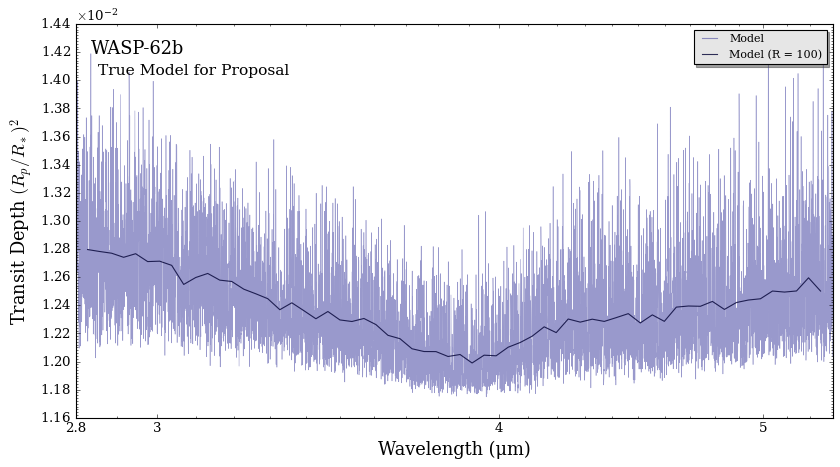

In [5]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectra = []   # Empty plot collection

# Add the two model spectra to the plot collection object
spectra = plot_collection(spectrum, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = True,
                        spectra_labels = ['Model'], colour_list = ['navy'], 
                        plt_label = 'True Model for Proposal', 
                        wl_axis = 'log', figure_shape = 'wide')

**Re-scattering PandExo data**

We can now re-scatter the PandExo data about the specific POSEIDON model of interest. You can also (optionally) bin the observations down to a lower spectral resolution and increase the number of transits (assuming PandExo was ran for a single transit).

The function below creates two new data files, one for each of the G395H NRS detectors, scattered about the POSEIDON model, in your data directory for WASP-62b.

In [6]:
from POSEIDON.instrument import generate_syn_data_from_file

# Specify number of transits observed by each instrument
N_trans = [1, 1]   # The 1 transit here refers to both NRS1 and NRS2, so 2 transits with G395H would be [2, 2]

# Specify spectral resolution for binning each raw dataset
R_to_bin = [100, 100]   # Let's bin down to R = 100 for clarity and retrieval speed

# Generate simulated data for the model using errors from data file
generate_syn_data_from_file(planet, wl, spectrum, data_dir, data, R_to_bin = R_to_bin,
                            N_trans = N_trans, label = model_name, Gauss_scatter = True)

Creating synthetic data
JWST_NIRSpec_G395H_NRS1
JWST_NIRSpec_G395H_NRS2


Let's examine our new model-specific simulated JWST spectrum:

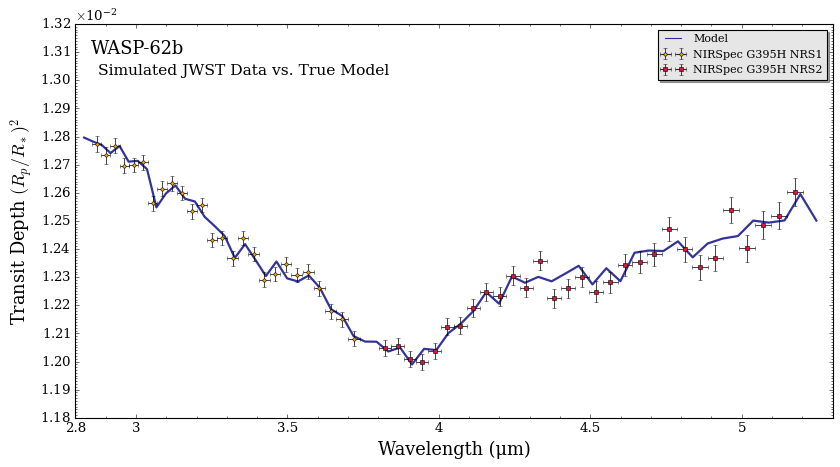

In [7]:
#***** Load the new dataset *****#
      
datasets_new = [planet_name + '_SYNTHETIC_JWST_NIRSpec_G395H_NRS1_' + model_name + '_N_trans_' + str(N_trans[0]) + '.dat',
                planet_name + '_SYNTHETIC_JWST_NIRSpec_G395H_NRS2_' + model_name + '_N_trans_' + str(N_trans[1]) + '.dat']

data_new = load_data(data_dir, datasets_new, instruments, wl)

# Create plot collection
spectra = []   
spectra = plot_collection(spectrum, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, data_properties = data_new, R_to_bin = 100, 
                        plot_full_res = False, show_data = True,
                        spectra_labels = ['Model'], colour_list = ['navy'], 
                        data_labels = ['NIRSpec G395H NRS1', 'NIRSpec G395H NRS2'],
                        data_colour_list = ['orange', 'crimson'],
                        y_min = 1.18e-2, y_max = 1.32e-2, 
                        figure_shape = 'wide', wl_axis = 'linear',
                        plt_label = 'Simulated JWST Data vs. True Model')

### Retrieving Simulated JWST Data

We are now ready to run a retrieval on the simulated JWST data for WASP-62b.

The priors for this simple model are straightforward to specify.

In [8]:
from POSEIDON.core import set_priors

#***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_X'] = 'uniform'

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [400, 2000]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_X'] = [-12, -1]                # Same for H2O and CH4

# Create prior object for retrieval
priors = set_priors(planet, star, model, data, prior_types, prior_ranges)

Since we already have the model description, opacity, and simulated JWST data loaded into memory we're basically done and can run the retrieval straight away!

<div class="alert alert-info">

  **Tip:**

  Running the cell below will only use a single core. This simple model isn't too bad (it should run in < 30 minutes), but for more complex models we strongly recommend running POSEIDON via a Python file in the terminal using multiple cores. An example Python script for this WASP-62b retrieval is included in the POSEIDON tutorial notebooks folder.

  You can run this multi-core retrieval on 4 cores via:

  ```
  mpirun -n 4 python -u WASP-62b_sim_data_retrieval.py
  ```
  
</div>

In [9]:
from POSEIDON.retrieval import run_retrieval

# Note: be sure to feed 'data_new' into the retrieval, or you'll be retrieving the raw PandExo flat line!

run_retrieval(planet, star, model, opac, data_new, priors, wl, P, P_ref, R = R, 
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest', 
              N_live = 1000, verbose = False, resume = False)

POSEIDON now running 'CH4_Search_With_JWST'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    4
 *****************************************************
POSEIDON retrieval finished in 0.39 hours
 ln(ev)=   495.51823083063516      +/-  0.10226808358823028     
 Total Likelihood Evaluations:        31030
 Sampling finished. Exiting MultiNest
Now generating 1000 sampled spectra and P-T profiles from the posterior distribution...
This process will take approximately 0.33 minutes
All done! Output files can be found in ./POSEIDON_output/WASP-62b/retrievals/results/


Let's plot the retrieval results!

<div class="alert alert-info">

  **Note:**

  Your corner plot may look slightly different to the one archived in this notebook, since you generated a dataset with a different Gaussian noise draw.

</div>

Generating corner plot ...


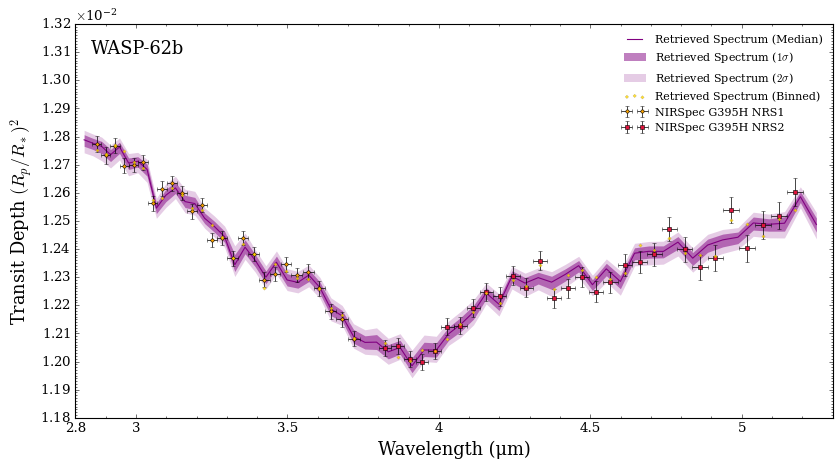

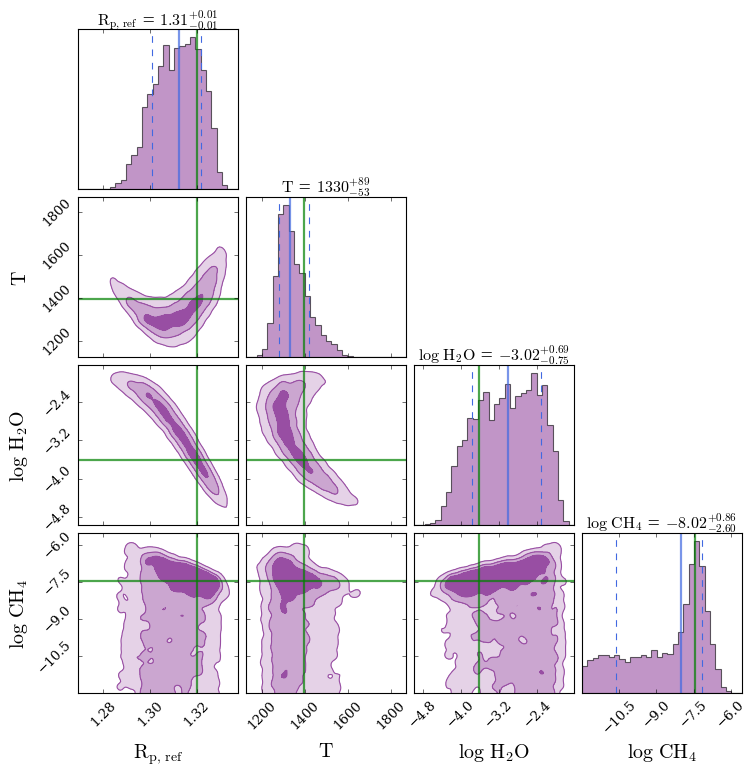

In [10]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved
from POSEIDON.corner import generate_cornerplot

#***** Plot retrieved transmission spectrum *****#

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data_new, R_to_bin = 100,
                                  data_labels = ['NIRSpec G395H NRS1', 'NIRSpec G395H NRS2'],
                                  data_colour_list = ['orange', 'crimson'],
                                  y_min = 1.18e-2, y_max = 1.32e-2, 
                                  figure_shape = 'wide', wl_axis = 'linear',
                                  plt_label = 'Simulated JWST Retrieval')

#***** Make corner plot *****#

fig_corner = generate_cornerplot(planet, model, true_vals = [R_p/R_J, PT_params[0], 
                                                             log_X_params[0], log_X_params[1]])

We see that, for this model, a single transit with G395H is sufficient to constrain the $\rm{H}_2 \rm{O}$ abundance but can only place an upper limit on $\rm{CH}_4$. However, the posterior peak for $\rm{CH}_4$ is very promising, suggesting that even a little more information could allow $\rm{CH}_4$ to be detected.

At this point, you could consider adding another transit with a different instrument mode (e.g. NIRSpec G235H) or trying 2 transits with G395H. Let's try the latter approach.

**Increasing to two G395H transits to save our science case** 

In [11]:
# Specify number of transits observed by each instrument
N_trans = [2, 2]   # 2 transits with G395H is [2, 2], since NRS1 and NRS2 are observed simultaneously

# Specify spectral resolution for binning each raw dataset
R_to_bin = [100, 100]   # Let's bin down to R = 100 for clarity and retrieval speed

# Generate simulated data for the model using errors from data file
generate_syn_data_from_file(planet, wl, spectrum, data_dir, data, R_to_bin = R_to_bin,
                            N_trans = N_trans, label = model_name, Gauss_scatter = True)

Creating synthetic data
JWST_NIRSpec_G395H_NRS1
JWST_NIRSpec_G395H_NRS2


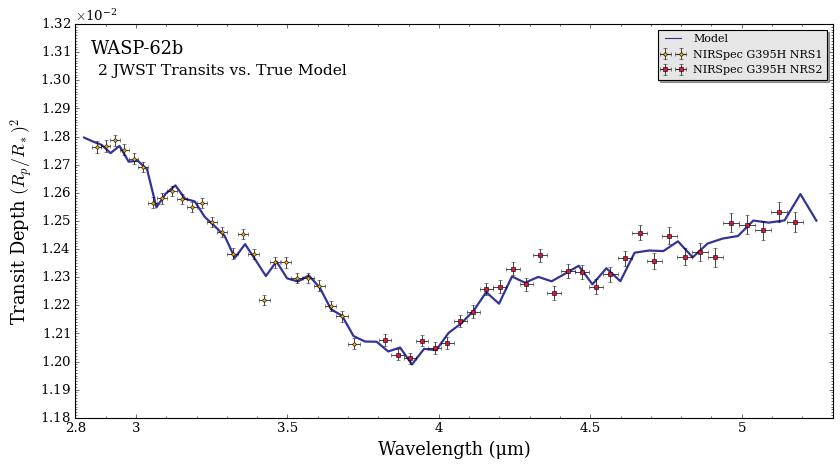

In [12]:
#***** Load the new dataset *****#
      
datasets_two_transits = [planet_name + '_SYNTHETIC_JWST_NIRSpec_G395H_NRS1_' + model_name + '_N_trans_' + str(N_trans[0]) + '.dat',
                         planet_name + '_SYNTHETIC_JWST_NIRSpec_G395H_NRS2_' + model_name + '_N_trans_' + str(N_trans[1]) + '.dat']

data_two_transits = load_data(data_dir, datasets_two_transits, instruments, wl)

# Create plot collection
spectra = []   
spectra = plot_collection(spectrum, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, data_properties = data_two_transits, R_to_bin = 100, 
                        plot_full_res = False, show_data = True,
                        spectra_labels = ['Model'], colour_list = ['navy'], 
                        data_labels = ['NIRSpec G395H NRS1', 'NIRSpec G395H NRS2'],
                        data_colour_list = ['orange', 'crimson'],
                        y_min = 1.18e-2, y_max = 1.32e-2, 
                        figure_shape = 'wide', wl_axis = 'linear',
                        plt_label = '2 JWST Transits vs. True Model')

We don't need to specify the priors again, since they'll be the same as above.

But we will re-define the model name so that the corner plot and retrieved spectra figures won't be overwritten. 

In [13]:
# New model name
model_name = 'CH4_Search_With_JWST_2_transits'

model_two_transits = define_model(model_name, bulk_species, param_species, 
                                  PT_profile = 'isotherm', cloud_model = 'cloud-free')

# Run retrieval
run_retrieval(planet, star, model_two_transits, opac, data_two_transits, priors, wl, P, P_ref, R = R, 
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest', 
              N_live = 1000, verbose = False, resume = False)

POSEIDON now running 'CH4_Search_With_JWST_2_transits'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    4
 *****************************************************
POSEIDON retrieval finished in 0.4 hours ln(ev)=   512.38345708933173      +/-  0.10674000727022560     
 Total Likelihood Evaluations:        32362
 Sampling finished. Exiting MultiNest

Now generating 1000 sampled spectra and P-T profiles from the posterior distribution...
This process will take approximately 0.32 minutes
All done! Output files can be found in ./POSEIDON_output/WASP-62b/retrievals/results/


Now the moment of truth: do we do better with 2 transits?

Generating corner plot ...


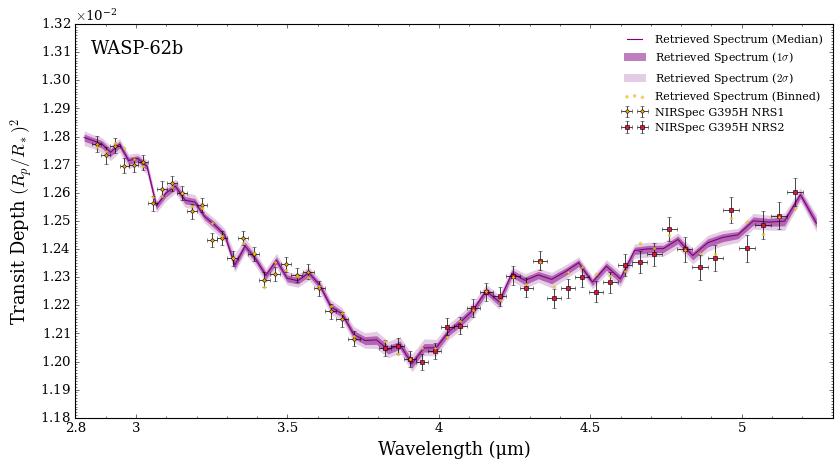

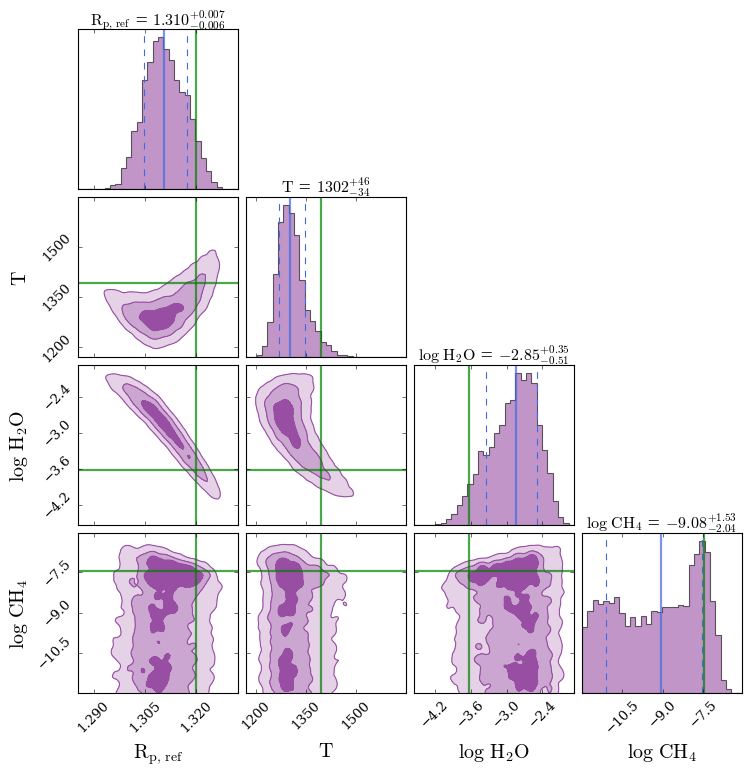

In [15]:
#***** Plot retrieved transmission spectrum *****#

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data_new, R_to_bin = 100,
                                  data_labels = ['NIRSpec G395H NRS1', 'NIRSpec G395H NRS2'],
                                  data_colour_list = ['orange', 'crimson'],
                                  y_min = 1.18e-2, y_max = 1.32e-2, 
                                  figure_shape = 'wide', wl_axis = 'linear',
                                  plt_label = 'Simulated JWST Retrieval')

#***** Make corner plot *****#

fig_corner = generate_cornerplot(planet, model_two_transits, true_vals = [R_p/R_J, PT_params[0], 
                                                                          log_X_params[0], log_X_params[1]])